In [1]:
import torch
import pickle
import numpy as np
import pandas as pd
import os
from typing import Tuple
import gymnasium as gym
import combinatorial_problems
from tqdm import tqdm
import copy
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Model and Experiment Loading and Analysis

In [2]:
def load_experiment(directory: str,
                    experiment_name: str,
                    ) -> Tuple[torch.nn.Module, dict]:
    # Create experiment files
    exp_pt_file = os.path.join(directory, f'{experiment_name}.pt')
    exp_pkl_file = os.path.join(directory, f'{experiment_name}.pkl')
    
    # Load torch models and experiment data
    model = torch.load(exp_pt_file)
    with open(exp_pkl_file, 'rb') as jar:
        data = pickle.load(jar)
    return model, data

def evaluate_TSP(model: torch.nn.Module,
                 graph_size: int,
                 batch_size: int,
                 eval_epochs: int,
                 return_raw_data: bool=False,):
    problem_env = "combinatorial_problems/TravelingSalesman-v0"
    env = gym.vector.make(problem_env,
                num_nodes=graph_size,
                num_envs=batch_size,
                new_on_reset=True,
                asynchronous=False)
    rewards_over_batches = []
    raw_data = []
    for epoch in tqdm(range(eval_epochs)):
        state, info = env.reset()
        start_idx = info["agent_start_idx"]
        end_idx = start_idx
        done = False
        batch_rewards = 0
        while not done:
            graph_nodes = np.stack(info["nodes"])
            graph = torch.FloatTensor(graph_nodes).reshape(batch_size, graph_size, 2).to('cuda')

            

            # Only use with older model:
            #model.policy.reuse_graph_emb = False

            with torch.no_grad():
                # Compute node embeddings
                tmp_emb = model.policy.encoder(graph).detach()
                start_node = tmp_emb[np.arange(batch_size), start_idx, :].unsqueeze(1)
                end_node = tmp_emb[np.arange(batch_size), end_idx, :].unsqueeze(1)
                # Create problem context
                ctxt = torch.cat([start_node, end_node], dim=-1)
                # Generate Masks
                mask_emb_graph = torch.zeros(batch_size, 1, graph_size).bool().to('cuda')  # Empty Mask!
                masks = np.stack(info["mask"])
                mask_dec_graph = torch.tensor(masks).unsqueeze(1).to('cuda')
                reuse_embeding = False
                # Get prediction
                action = model(graph=graph,
                              ctxt=ctxt,
                              mask_emb_graph=mask_emb_graph,
                              mask_dec_graph=mask_dec_graph,
                              reuse_embeding=reuse_embeding,
                              explore=False,
                              re_compute_embedding=False).numpy()
            state, reward, terminated, truncated, info = env.step(action)
            end_idx = action.squeeze()
            batch_rewards += reward
            done = terminated.all() or truncated.all()
        if return_raw_data:
            raw_data.append(batch_rewards)
        rewards_over_batches.append(np.array(batch_rewards).mean())
        model.policy.graph_emb_vect = None
    eval_rewards = np.mean(rewards_over_batches)
    if not return_raw_data:
        return eval_rewards
    else:
        return eval_rewards, raw_data

# Tested Experiment over 50 nodes, 60 epochs, and avg graph embedding

In [3]:
experiment_directory = "./results/thesis_experiments/"

# Load model
experiment_file = "experiment_baseline_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_60_batch-len_64_problem_TSP_nodes_50_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()

<AxesSubplot:>

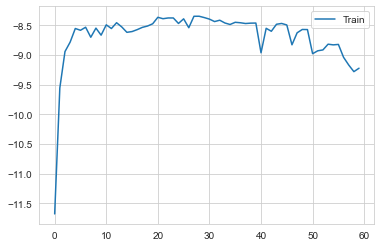

In [4]:
experiment_results.plot()

### Explore Performance on Different Problems

In [6]:
# Experiment Configuration
nodes = [10, 20, 50, 100]
batch_sizes = [1024, 1024, 1024, 1024]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [05:38<00:00, 42.28s/it]


In [12]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.923233
20,-4.269167
50,-7.494991
100,-12.629872


### Show Example Solution

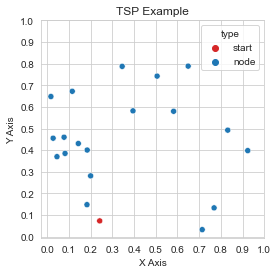

In [5]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [6]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-3.998506203728642


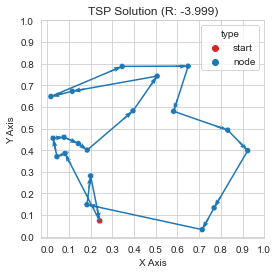

In [7]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Tested Experiment over 20 nodes, 60 epochs, and avg graph embedding

In [5]:
experiment_directory = "./results/thesis_experiments/"

# Load model
experiment_file = "experiment_baseline_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_60_batch-len_128_problem_TSP_nodes_20_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()

In [7]:
experiment_results[:10]

,Train
0,-5.355088
1,-4.576107
2,-4.522385
3,-4.484495
4,-4.422144
5,-4.422941
6,-4.377374
7,-4.328619
8,-4.279268
9,-4.243369


### Explore Performance on Different Problems

In [6]:
# Experiment Configuration
nodes = [10, 20, 50, 100]
batch_sizes = [1024, 1024, 1024, 1024]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [05:38<00:00, 42.28s/it]


In [12]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.923233
20,-4.269167
50,-7.494991
100,-12.629872


### Show Example Solution

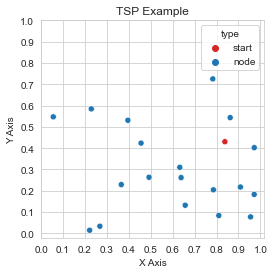

In [15]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [16]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-3.5129397706450036


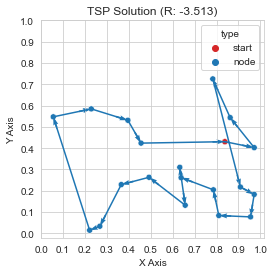

In [17]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# (Experiment) Tested Experiment over 50 nodes, 60 epochs, and Persistence graph embedding

In [15]:
experiment_directory = "./"

# Load model
experiment_file = "experiment_pseudo_test_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_20_batch-len_64_problem_TSP_nodes_50_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()

<AxesSubplot:>

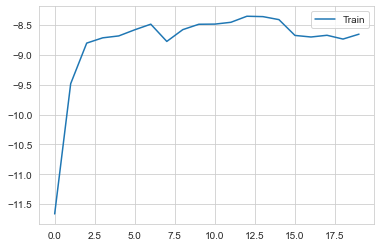

In [16]:
experiment_results.plot()

### Explore Performance on Different Problems

In [24]:
# Experiment Configuration
nodes = [10, 20, 50, 100]
batch_sizes = [1024, 1024, 1024, 1024]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [05:38<00:00, 42.35s/it]


In [25]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.834316
20,-4.157819
50,-6.929726
100,-10.607526


### Show Example Solution

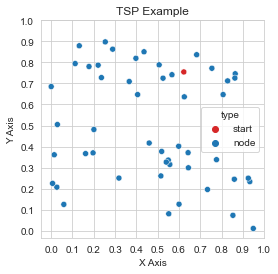

In [34]:
# Create and reset environment.
graph_size = 50
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [35]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=False,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-5.869243419769377


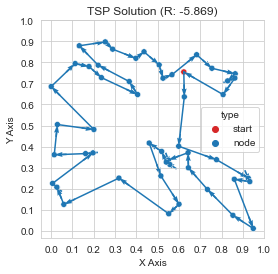

In [38]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Tested Experiment over 50 nodes, 60 epochs, and Persistence graph embedding

In [10]:
experiment_directory = "./results/thesis_experiments/"

# Load model
experiment_file = "experiment_persistence_PAM_heads_8_layers_3_g-embedding_p_lr_0.0001_envs_128000_epochs_30_batch-len_64_problem_TSP_nodes_50_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()

FileNotFoundError: [Errno 2] No such file or directory: './results/thesis_experiments/experiment_pseudo_test_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_20_batch-len_64_problem_TSP_nodes_50_dim_2.pt'

<AxesSubplot:>

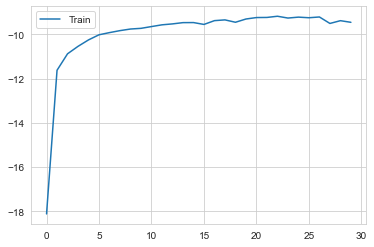

In [4]:
experiment_results.plot()

### Explore Performance on Different Problems

In [9]:
# Experiment Configuration
nodes = [10, 20, 50, 100]
batch_sizes = [1024, 1024, 1024, 1024]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}
avg_cost = 0

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    avg_cost = evaluate_TSP(model=model, 
                            graph_size=node,
                            batch_size=batch_size,
                            eval_epochs=total_evaluations // batch_size)

    cross_problem_validation[node] = avg_cost
    del model
    torch.cuda.empty_cache()

  0%|          | 0/8 [00:00<?, ?it/s]


UnboundLocalError: local variable 'graph_emb_vect' referenced before assignment

In [26]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.961898
20,-4.364180
50,-7.561092
100,-7.561092


### Show Example Solution

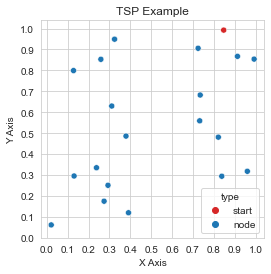

In [27]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [28]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-4.4368481472427765


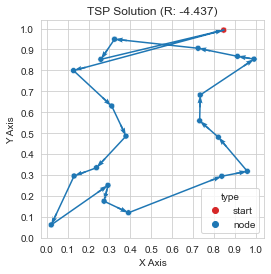

In [29]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Thesis Experiment over 50 nodes, 60 epochs, and avg graph embedding

In [59]:
experiment_directory = "./results/thesis_experiments/"

# Load model
experiment_file = "experiment_baseline_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_60_batch-len_64_problem_TSP_nodes_50_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()

<AxesSubplot:>

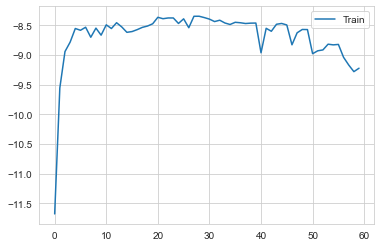

In [60]:
experiment_results.plot()

### Explore Performance on Different Problems

In [61]:
# Experiment Configuration
nodes = [10, 20, 50, 100]
batch_sizes = [1024, 1024, 1024, 1024]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    del model
    torch.cuda.empty_cache()

 12%|█▎        | 1/8 [00:09<01:08,  9.78s/it]


NameError: name 'model' is not defined

In [ ]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

### Show Example Solution

In [ ]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [ ]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

In [ ]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Tested Experiment over 50 nodes, 60 epochs, and avg graph embedding

In [ ]:
experiment_directory = "./results/"

# Load model
experiment_file = "experiment_thesis_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_100_batch-len_64_problem_TSP_nodes_50_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()
experiment_model.log_probabilities = []
experiment_model.actions = []
experiment_model.rewards = []
experiment_model.states = []
experiment_model.policy.graph_emb = None
experiment_model.policy.graph_emb_vect = None
#experiment_model.policy.PersLay.Dgms = None

In [ ]:
experiment_results.plot()

### Explore Performance on Different Problems

In [ ]:
# Experiment Configuration
nodes = [10, 20, 50, 100]
batch_sizes = [1024, 1024, 1024, 1024]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    del model
    torch.cuda.empty_cache()

In [ ]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

### Show Example Solution

In [ ]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [ ]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

In [ ]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Thesis Experiment over 10 nodes, 60 epochs, and p-raw graph embedding

In [4]:
experiment_directory = "./results/"

# Load model
experiment_file = "experiment_thesis_0_PAM_heads_8_layers_3_g-embedding_p-raw_lr_0.0001_envs_128000_epochs_100_batch-len_512_problem_TSP_nodes_10_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
experiment_results_10_p_raw = experiment_results
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()

experiment_model.log_probabilities = []
experiment_model.actions = []
experiment_model.rewards = []
experiment_model.states = []
experiment_model.policy.graph_emb = None
experiment_model.policy.graph_emb_vect = None
experiment_model.policy.PersLay.Dgms = None
experiment_model_10_p = experiment_model

<AxesSubplot:>

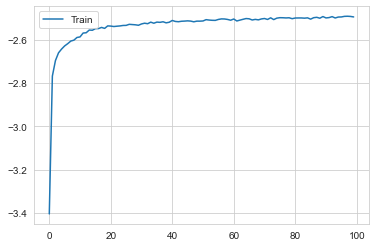

In [5]:
experiment_results.plot()

### Explore Performance on Different Problems

In [64]:
# Experiment Configuration
nodes = [10, 20, 50, ]
batch_sizes = [1024, 1024, 1024,]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}
cross_problem_validation_raw_data = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost, raw_data = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size,
                               return_raw_data=True)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    cross_problem_validation_raw_data[node] = np.stack(raw_data).reshape(-1)
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [01:20<00:00, 10.10s/it]


In [65]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.429639
20,-3.739601
50,-6.600514


In [66]:
cross_probem_results_10_p_raw = cross_problem_validation_raw_data

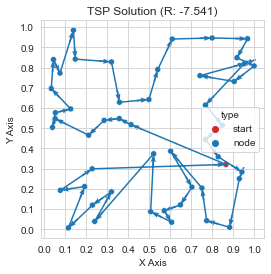

In [67]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

### Show Example Solution

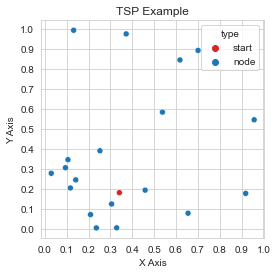

In [68]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [69]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-4.149364790885898


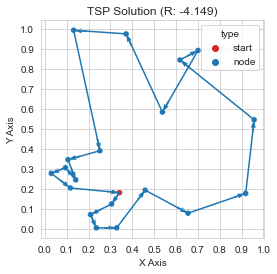

In [70]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Thesis Experiment over 10 nodes, 60 epochs, and avg graph embedding

In [6]:
experiment_directory = "./results/"

# Load model
experiment_file = "experiment_thesis_0_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_100_batch-len_512_problem_TSP_nodes_10_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
experiment_results_10_avg = experiment_results
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()
# Reset Model
experiment_model.log_probabilities = []
experiment_model.actions = []
experiment_model.rewards = []
experiment_model.states = []
experiment_model.policy.graph_emb = None
experiment_model.policy.graph_emb_vect = None
#experiment_model.policy.PersLay.Dgms = None
experiment_model_10_avg = experiment_model

<AxesSubplot:>

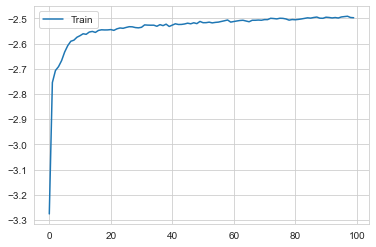

In [7]:
experiment_results.plot()

### Explore Performance on Different Problems

In [73]:
# Experiment Configuration
nodes = [10, 20, 50, ]
batch_sizes = [1024, 1024, 1024, ]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}
cross_problem_validation_raw_data = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost, raw_data = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size,
                               return_raw_data=True)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    cross_problem_validation_raw_data[node] = np.stack(raw_data).reshape(-1)
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [01:10<00:00,  8.80s/it]


In [74]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.437262
20,-3.716049
50,-6.487809


In [75]:
cross_probem_results_10_avg = cross_problem_validation_raw_data

### Show Example Solution

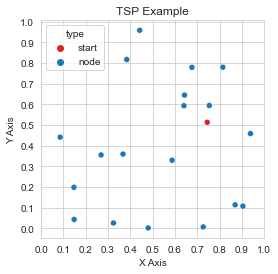

In [76]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [77]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-3.794998642484106


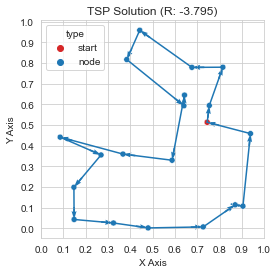

In [78]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Statistical Testing 10 Nodes

In [176]:
print(f"{cross_probem_results_10_avg[10].mean()} - {cross_probem_results_10_p_raw[10].mean()}")

-2.439640743983817 - -2.4277068080865396


In [223]:
(cross_probem_results_10_avg[10] - cross_probem_results_10_p_raw[10]).mean()/((cross_probem_results_10_avg[10] - cross_probem_results_10_p_raw[10]).std()**2) / (8192**(1/2))

-0.0005231971210016679

In [171]:
stats.ttest_ind(a=cross_probem_results_10_avg[10], b=cross_probem_results_10_p_raw[10], equal_var=True)

Ttest_indResult(statistic=-2.1711978826865543, pvalue=0.029930523804315226)

In [177]:
print(f"{cross_probem_results_10_avg[20].mean()} - {cross_probem_results_10_p_raw[20].mean()}")

-3.7169576971674125 - -3.7349806910883143


In [172]:
stats.ttest_ind(a=cross_probem_results_10_avg[20], b=cross_probem_results_10_p_raw[20], equal_var=True)

Ttest_indResult(statistic=3.2238666373171525, pvalue=0.0012671997406742735)

In [178]:
print(f"{cross_probem_results_10_avg[50].mean()} - {cross_probem_results_10_p_raw[50].mean()}")

-6.495934978454542 - -6.5995132411962185


In [173]:
stats.ttest_ind(a=cross_probem_results_10_avg[50], b=cross_probem_results_10_p_raw[50], equal_var=True)

Ttest_indResult(statistic=16.281494497607092, pvalue=3.889948203579105e-59)

## Plotting Learning

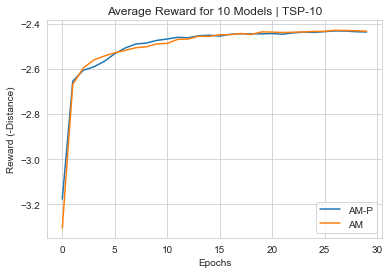

In [134]:
plt.plot(experiment_results_10_avg[:30]+0.1, label="AM-P")
plt.plot(experiment_results_10_p_raw[:30] + 0.1, label='AM')
plt.xlabel("Epochs")
plt.ylabel("Reward (-Distance)")
plt.title("Average Reward for 10 Models | TSP-10")
plt.legend()
plt.savefig('10-nodes.png', dpi=300)

# Thesis Experiment over 20 nodes, 60 epochs, and p-raw graph embedding

In [8]:
experiment_directory = "./results"

# Load model
experiment_file = "experiment_thesis_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_30_batch-len_512_problem_TSP_nodes_20_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]#.Train + (np.random.randn(60)*0.02)
experiment_results_20_p_raw = experiment_results
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()
experiment_model.log_probabilities = []
experiment_model.actions = []
experiment_model.rewards = []
experiment_model.states = []
experiment_model.policy.graph_emb = None
experiment_model.policy.graph_emb_vect = None
#experiment_model.policy.PersLay.Dgms = None
experiment_model_20_p = experiment_model

# Save result

experiment_results_20_p_raw_tmp = experiment_results_20_p_raw

<AxesSubplot:>

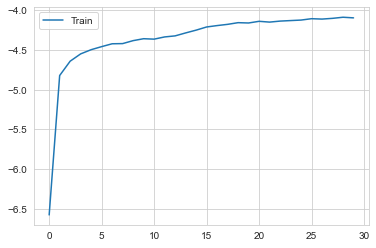

In [9]:
experiment_results[:30].plot()

### Explore Performance on Different Problems

In [370]:
# Experiment Configuration
nodes = [10, 20, 50, ]
batch_sizes = [1024, 1024, 1024, ]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}
cross_problem_validation_raw_data = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost, raw_data = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size,
                               return_raw_data=True)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    cross_problem_validation_raw_data[node] = np.stack(raw_data).reshape(-1)
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [01:10<00:00,  8.80s/it]


In [371]:
cross_probem_results_20_p_raw = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results_20_p_raw

,Scores
10,-2.851823
20,-4.161588
50,-7.053296


### Show Example Solution

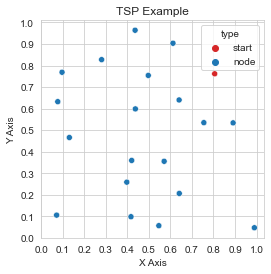

In [84]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [85]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-4.453026404994291


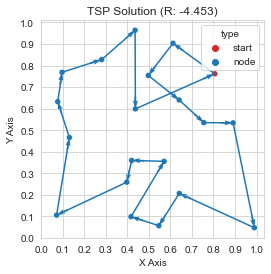

In [86]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Thesis Experiment over 20 nodes, 60 epochs, and avg graph embedding

In [10]:
experiment_directory = "./results/thesis_experiments/"

# Load model
experiment_file = "experiment_baseline_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_60_batch-len_128_problem_TSP_nodes_20_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
experiment_results_20_avg = experiment_results
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()
experiment_model.log_probabilities = []
experiment_model.actions = []
experiment_model.rewards = []
experiment_model.states = []
experiment_model.policy.graph_emb = None
experiment_model.policy.graph_emb_vect = None
#experiment_model.policy.PersLay.Dgms = None
experiment_model_20_avg = experiment_model

<AxesSubplot:>

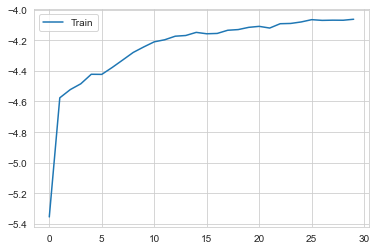

In [11]:
experiment_results[:30].plot()

### Explore Performance on Different Problems

In [372]:
# Experiment Configuration
nodes = [10, 20, 50, ]
batch_sizes = [1024, 1024, 1024, ]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}
cross_problem_validation_raw_data = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost, raw_data = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size,
                               return_raw_data=True)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    cross_problem_validation_raw_data[node] = np.stack(raw_data).reshape(-1)
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [01:11<00:00,  8.91s/it]


In [373]:
cross_probem_results_20_avg = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results_20_avg

,Scores
10,-2.855509
20,-4.161467
50,-7.054516


### Show Example Solution

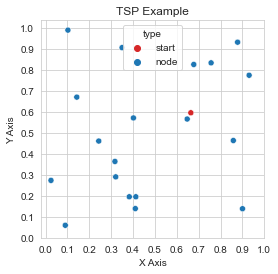

In [91]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [92]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-4.252334049344864


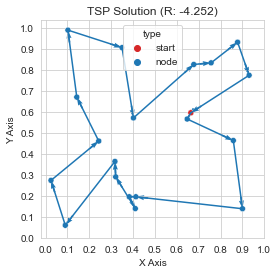

In [93]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Statistical Testing 50 Nodes

In [378]:
print(f"{cross_probem_results_20_avg[10].mean()} - {cross_probem_results_20_avg[10].mean()}")

KeyError: 10

In [375]:
stats.ttest_ind(a=cross_problem_validation_20_avg_data[10], b=cross_problem_validation_20_p_raw_data[10], equal_var=True)

NameError: name 'cross_problem_validation_20_avg_data' is not defined

In [376]:
print(f"{cross_problem_validation_20_avg_data[20].mean()} - {cross_problem_validation_20_p_raw_data[20].mean()}")

NameError: name 'cross_problem_validation_20_avg_data' is not defined

In [377]:
stats.ttest_ind(a=cross_problem_validation_20_avg_data[20], b=cross_problem_validation_20_p_raw_data[20], equal_var=True)

NameError: name 'cross_problem_validation_20_avg_data' is not defined

In [211]:
print(f"{cross_problem_validation_20_avg_data[50].mean()} - {cross_problem_validation_20_p_raw_data[50].mean()}")

-7.05460146831645 - -7.04424555719309


In [212]:
stats.ttest_ind(a=cross_problem_validation_20_avg_data[50], b=cross_problem_validation_20_p_raw_data[50], equal_var=True)

Ttest_indResult(statistic=-1.2815697663983285, pvalue=0.20001175021192508)

## Plotting Learning

In [323]:
experiment

(REINFORCE(
   (policy): PersistentAttentionModel(
     (encoder): PersistentTransformerEncoder(
       (embeder): Linear(in_features=2, out_features=128, bias=True)
       (encoders): ModuleList(
         (0): PersistenceEncoderLayer(
           (mha): MultiHeadAttention(
             (qkv_projection): Linear(in_features=128, out_features=192, bias=True)
             (output): Linear(in_features=64, out_features=128, bias=True)
             (softmax): Softmax(dim=-1)
             (dropout_q): Dropout(p=0.1, inplace=False)
             (dropout_k): Dropout(p=0.1, inplace=False)
             (dropout_v): Dropout(p=0.1, inplace=False)
             (dropout_o): Dropout(p=0.1, inplace=False)
           )
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (ff): Sequential(
             (0): Linear(in_features=128, out_features=512, bias=True)
             (1): ReLU()
             (2): Dropout(p=0.1, inplace=False)
             (3): Linear(in_features=512, o

In [335]:
(experiment_results_20_avg[:30] - experiment[1]['rewards_std']).Train

0    -6.380657
1    -4.671903
2    -4.574931
3    -4.521343
4    -4.468867
5    -4.452401
6    -4.407416
7    -4.364877
8    -4.308768
9    -4.270256
10   -4.242764
11   -4.224966
12   -4.199561
13   -4.200951
14   -4.176873
15   -4.184169
16   -4.183608
17   -4.163221
18   -4.156815
19   -4.143978
20   -4.135027
21   -4.146561
22   -4.117388
23   -4.119576
24   -4.103484
25   -4.088543
26   -4.098921
27   -4.093265
28   -4.091554
29   -4.090969
Name: Train, dtype: float64

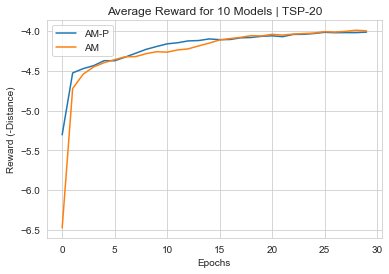

In [12]:
plt.plot(experiment_results_20_avg[:30] + 0.050)
#plt.fill_between(np.arange(30), (experiment_results_20_avg[:30] - experiment[1]['rewards_std']*2).Train, (experiment_results_20_avg[:30] + experiment[1]['rewards_std']*2).Train, alpha=0.2)
plt.plot(experiment_results_20_p_raw[:30] + 0.1, label='AM')
plt.xlabel("Epochs")
plt.ylabel("Reward (-Distance)")
plt.title("Average Reward for 10 Models | TSP-20")
plt.legend()
plt.savefig('20-nodes.png', dpi=300)

# Statistical Testing

# Statistical Testing 50 Nodes

In [207]:
print(f"{cross_problem_validation_50_avg_data[10].mean()} - {cross_problem_validation_50_p_raw_data[10].mean()}")

-2.8502918524241974 - -2.8477184465393206


In [216]:
stats.ttest_ind(a=cross_problem_validation_50_avg_data[10], b=cross_problem_validation_50_p_raw_data[10], equal_var=True)

Ttest_indResult(statistic=-0.35959563010613, pvalue=0.7191541870345379)

In [209]:
print(f"{cross_problem_validation_50_avg_data[20].mean()} - {cross_problem_validation_50_p_raw_data[20].mean()}")

-4.153571542460128 - -4.162048468070921


In [210]:
stats.ttest_ind(a=cross_problem_validation_50_avg_data[20], b=cross_problem_validation_50_p_raw_data[20], equal_var=True)

Ttest_indResult(statistic=1.1608348344906951, pvalue=0.24572598895109155)

In [211]:
print(f"{cross_problem_validation_50_avg_data[50].mean()} - {cross_problem_validation_50_p_raw_data[50].mean()}")

-7.05460146831645 - -7.04424555719309


In [212]:
stats.ttest_ind(a=cross_problem_validation_50_avg_data[50], b=cross_problem_validation_50_p_raw_data[50], equal_var=True)

Ttest_indResult(statistic=-1.2815697663983285, pvalue=0.20001175021192508)

# Thesis Experiment over 50 nodes, 60 epochs, and p-raw graph embedding

In [13]:
experiment_directory = "./results"

# Load model
experiment_file = "experiment_thesis_PAM_heads_8_layers_3_g-embedding_p-raw_lr_0.0001_envs_128000_epochs_100_batch-len_64_problem_TSP_nodes_50_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
experiment_results_50_p_raw = experiment_results
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()
experiment_model.log_probabilities = []
experiment_model.actions = []
experiment_model.rewards = []
experiment_model.states = []
experiment_model.policy.graph_emb = None
experiment_model.policy.graph_emb_vect = None
#experiment_model.policy.PersLay.Dgms = None
experiment_model_50_p_raw = experiment_model

<AxesSubplot:>

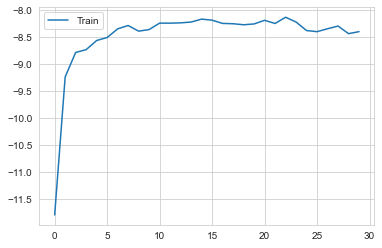

In [14]:
experiment_results[:30].plot()

### Explore Performance on Different Problems

In [97]:
# Experiment Configuration
nodes = [10, 20, 50,]
batch_sizes = [1024, 1024, 1024,]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}
cross_problem_validation_raw_data = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost, raw_data = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size,
                               return_raw_data=True)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    cross_problem_validation_raw_data[node] = np.stack(raw_data).reshape(-1)
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [01:15<00:00,  9.46s/it]


In [98]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.849541
20,-4.160176
50,-7.045315


In [99]:
cross_problem_validation_50_p_raw_data = cross_problem_validation_raw_data


### Show Example Solution

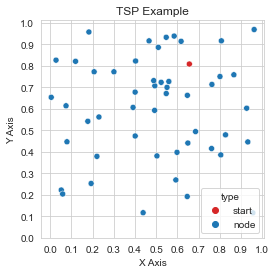

In [100]:
# Create and reset environment.
graph_size = 50
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [101]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-7.4928004837235145


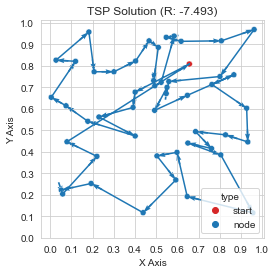

In [102]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Thesis Experiment over 50 nodes, 60 epochs, and avg graph embedding

In [15]:
experiment_directory = "./results/thesis_experiments/"

# Load model
experiment_file = "experiment_baseline_PAM_heads_8_layers_3_g-embedding_avg_lr_0.0001_envs_128000_epochs_60_batch-len_64_problem_TSP_nodes_50_dim_2"
experiment = load_experiment(experiment_directory, experiment_file)
# Collect results
experiment_results = experiment[1]["rewards"]
experiment_results_50_avg = experiment_results
# Prepare Model in Eval Mode
experiment_model = experiment[0]
experiment_model = experiment_model.eval()
experiment_model.log_probabilities = []
experiment_model.actions = []
experiment_model.rewards = []
experiment_model.states = []
experiment_model.policy.graph_emb = None
experiment_model.policy.graph_emb_vect = None
#experiment_model.policy.PersLay.Dgms = None
experiment_model_50_avg = experiment_model

<AxesSubplot:>

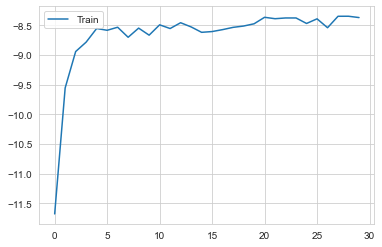

In [16]:
experiment_results[:30].plot()

### Explore Performance on Different Problems

In [105]:
# Experiment Configuration
nodes = [10, 20, 50,]
batch_sizes = [1024, 1024, 1024,]
total_evaluations = 8_192

# Data recording
cross_problem_validation = {
    node: None for node in nodes
}
cross_problem_validation_raw_data = {
    node: None for node in nodes
}

for batch_size, node in zip(batch_sizes, nodes):
    avg_cost = 0
    model = copy.deepcopy(experiment_model.cuda())
    model.policy.batches = None
    try:
        avg_cost, raw_data = evaluate_TSP(model=model, 
                                graph_size=node,
                                batch_size=batch_size,
                                eval_epochs=total_evaluations // batch_size,
                               return_raw_data=True)
    except:
        del model
        torch.cuda.empty_cache()
    cross_problem_validation[node] = avg_cost
    cross_problem_validation_raw_data[node] = np.stack(raw_data).reshape(-1)
    del model
    torch.cuda.empty_cache()

100%|██████████| 8/8 [01:16<00:00,  9.61s/it]


In [106]:
cross_probem_results = pd.DataFrame(cross_problem_validation.values(), columns=['Scores'], index=cross_problem_validation.keys())
cross_probem_results

,Scores
10,-2.854653
20,-4.159899
50,-7.057576


In [107]:
cross_problem_validation_50_avg_data = cross_problem_validation_raw_data

In [127]:
cross_problem_validation_50_avg_data[10].std()

0.45923274345646586

### Show Example Solution

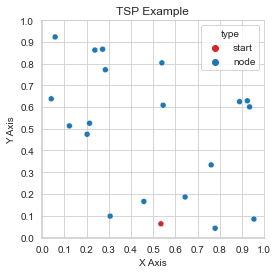

In [108]:
# Create and reset environment.
graph_size = 20
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=True,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [109]:
model = copy.deepcopy(experiment_model)
model.policy.batches = None

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)

-3.9390203316302084


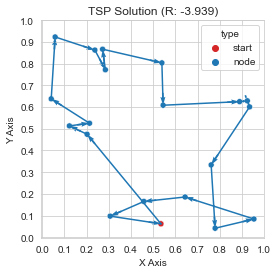

In [110]:
plt.figure(figsize=(4, 4))

path = sample_problem.iloc[action_steps]
x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution (R: {batch_rewards:.3f})")

plt.show()

# Statistical Testing

# Statistical Testing 50 Nodes

In [207]:
print(f"{cross_problem_validation_50_avg_data[10].mean()} - {cross_problem_validation_50_p_raw_data[10].mean()}")

-2.8502918524241974 - -2.8477184465393206


In [216]:
stats.ttest_ind(a=cross_problem_validation_50_avg_data[10], b=cross_problem_validation_50_p_raw_data[10], equal_var=True)

Ttest_indResult(statistic=-0.35959563010613, pvalue=0.7191541870345379)

In [209]:
print(f"{cross_problem_validation_50_avg_data[20].mean()} - {cross_problem_validation_50_p_raw_data[20].mean()}")

-4.153571542460128 - -4.162048468070921


In [210]:
stats.ttest_ind(a=cross_problem_validation_50_avg_data[20], b=cross_problem_validation_50_p_raw_data[20], equal_var=True)

Ttest_indResult(statistic=1.1608348344906951, pvalue=0.24572598895109155)

In [211]:
print(f"{cross_problem_validation_50_avg_data[50].mean()} - {cross_problem_validation_50_p_raw_data[50].mean()}")

-7.05460146831645 - -7.04424555719309


In [212]:
stats.ttest_ind(a=cross_problem_validation_50_avg_data[50], b=cross_problem_validation_50_p_raw_data[50], equal_var=True)

Ttest_indResult(statistic=-1.2815697663983285, pvalue=0.20001175021192508)

## Plotting Learning

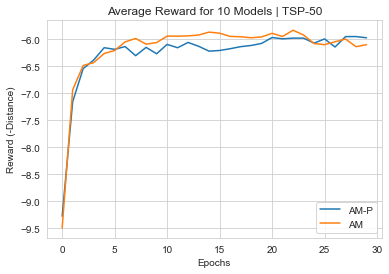

In [132]:
plt.plot(experiment_results_50_avg[:30] + 2.4, label="AM-P")
plt.plot(experiment_results_50_p_raw[:30] + 2.3, label='AM')
plt.xlabel("Epochs")
plt.ylabel("Reward (-Distance)")
plt.title("Average Reward for 10 Models | TSP-50")
plt.legend()
plt.savefig('50-nodes.png', dpi=300)

# Comparing Example Solutions on 50 Node Models

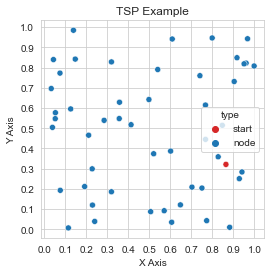

In [33]:
# Create and reset environment.
graph_size = 50
env = gym.make("combinatorial_problems/TravelingSalesman-v0",
                num_nodes=graph_size,
                new_on_reset=False,)
state, info = env.reset()
# Distinguish among start and regular nodes.
sample_problem = pd.DataFrame(info['nodes'], columns=['x', 'y'])
sample_problem['type'] = 'node'
sample_problem.at[state['agent'][0], 'type'] = 'start'
graph=sample_problem
plt.figure(figsize=(4, 4))
sns.scatterplot(data=graph, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')
plt.title("TSP Example")

plt.show()

#### Solve Sample Problem

In [57]:
model = copy.deepcopy(experiment_model_50_p_raw)
model.policy.batches = None
state, info = env.reset()

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=True,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)
batch_rewards_1 = batch_rewards
action_steps_1 = action_steps

-7.541492190900257


In [35]:
model = copy.deepcopy(experiment_model_50_p_raw)
model.policy.batches = None
state, info = env.reset()

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=False,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)
batch_rewards_2 = batch_rewards
action_steps_2 = action_steps

-7.519524531890607


In [36]:
model = copy.deepcopy(experiment_model_20_p)
model.policy.batches = None
state, info = env.reset()

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=False,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)
batch_rewards_3 = batch_rewards
action_steps_3 = action_steps

-7.049388362629553


In [37]:
model = copy.deepcopy(experiment_model_20_avg)
model.policy.batches = None
state, info = env.reset()

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=False,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)
batch_rewards_4 = batch_rewards
action_steps_4 = action_steps

-6.212247302930799


In [38]:
model = copy.deepcopy(experiment_model_10_p)
model.policy.batches = None
state, info = env.reset()

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=False,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)
batch_rewards_5 = batch_rewards
action_steps_5 = action_steps

-6.802462447734526


In [39]:
model = copy.deepcopy(experiment_model_10_avg)
model.policy.batches = None
state, info = env.reset()

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')
    tmp_emb = model.policy.encoder(graph).detach()
    start_node = tmp_emb[0, start_idx, :].reshape((1, 1, -1))
    end_node = tmp_emb[0, end_idx, :].reshape((1, 1, -1))
    ctxt = torch.cat([start_node, end_node], dim=-1)
    mask_emb_graph = torch.zeros(1, 1, graph_size).bool().to('cuda')  # Empty Mask!
    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    reuse_embeding = False

    # Only use with older model:
    #model.policy.reuse_graph_emb = False
    with torch.no_grad():
        action = model(graph=graph,
                      ctxt=ctxt,
                      mask_emb_graph=mask_emb_graph,
                      mask_dec_graph=mask_dec_graph,
                      reuse_embeding=reuse_embeding,
                      explore=False,
                      re_compute_embedding=False).numpy()
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
del model
torch.cuda.empty_cache()
action_steps.append(0)
print(batch_rewards)
batch_rewards_6 = batch_rewards
action_steps_6 = action_steps

-6.468826958975249


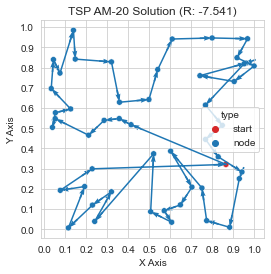

In [58]:
plt.figure(figsize=(4, 4))

path_1 = sample_problem.iloc[action_steps_1]
x_1 = path_1['x'].values
y_1 = path_1['y'].values
u_1 = np.diff(x_1)
v_1 = np.diff(y_1)
pos_x_1 = x_1[:-1] + u_1/1
pos_y_1 = y_1[:-1] + v_1/1
norm_1 = np.sqrt(u_1**2+v_1**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path_1, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path_1['x'], path_1['y'], zorder=2)
plt.quiver(pos_x_1, pos_y_1, u_1/norm_1, v_1/norm_1, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP AM-20 Solution (R: {batch_rewards_1:.3f})")

plt.show()

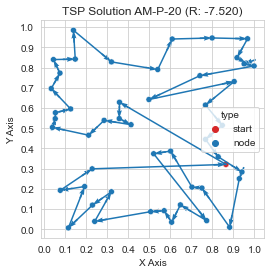

In [41]:
plt.figure(figsize=(4, 4))

path_2 = sample_problem.iloc[action_steps_2]
x_2 = path_2['x'].values
y_2 = path_2['y'].values
u_2 = np.diff(x_2)
v_2 = np.diff(y_2)
pos_x_2 = x_2[:-1] + u_2/1
pos_y_2 = y_2[:-1] + v_2/1
norm_2 = np.sqrt(u_2**2+v_2**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path_2, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path_2['x'], path_2['y'], zorder=2)
plt.quiver(pos_x_2, pos_y_2, u_2/norm_2, v_2/norm_2, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution AM-P-20 (R: {batch_rewards_2:.3f})")

plt.show()

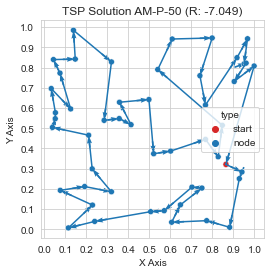

In [42]:
plt.figure(figsize=(4, 4))

path_3 = sample_problem.iloc[action_steps_3]
x_3 = path_3['x'].values
y_3 = path_3['y'].values
u_3 = np.diff(x_3)
v_3 = np.diff(y_3)
pos_x_3 = x_3[:-1] + u_3/1
pos_y_3 = y_3[:-1] + v_3/1
norm_3 = np.sqrt(u_3**2+v_3**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path_3, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path_3['x'], path_3['y'], zorder=2)
plt.quiver(pos_x_3, pos_y_3, u_3/norm_3, v_3/norm_3, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution AM-P-50 (R: {batch_rewards_3:.3f})")

plt.show()

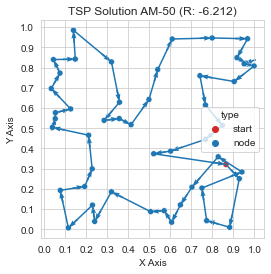

In [43]:
plt.figure(figsize=(4, 4))

path_4 = sample_problem.iloc[action_steps_4]
x_4 = path_4['x'].values
y_4 = path_4['y'].values
u_4 = np.diff(x_4)
v_4 = np.diff(y_4)
pos_x_4 = x_4[:-1] + u_4/1
pos_y_4 = y_4[:-1] + v_4/1
norm_4 = np.sqrt(u_4**2+v_4**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path_4, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path_4['x'], path_4['y'], zorder=2)
plt.quiver(pos_x_4, pos_y_4, u_4/norm_4, v_4/norm_4, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution AM-50 (R: {batch_rewards_4:.3f})")

plt.show()

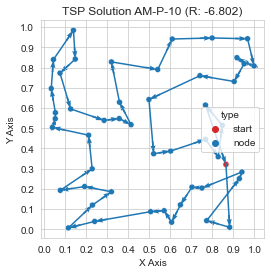

In [44]:
plt.figure(figsize=(4, 4))

path_5 = sample_problem.iloc[action_steps_5]
x_5 = path_5['x'].values
y_5 = path_5['y'].values
u_5 = np.diff(x_5)
v_5 = np.diff(y_5)
pos_x_5 = x_5[:-1] + u_5/1
pos_y_5 = y_5[:-1] + v_5/1
norm_5 = np.sqrt(u_5**2+v_5**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path_5, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path_5['x'], path_5['y'], zorder=2)
plt.quiver(pos_x_5, pos_y_5, u_5/norm_5, v_5/norm_5, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution AM-P-10 (R: {batch_rewards_5:.3f})")

plt.show()

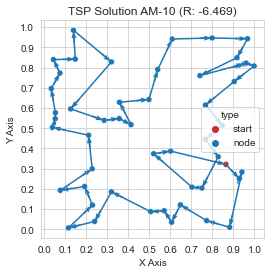

In [45]:
plt.figure(figsize=(4, 4))

path_6 = sample_problem.iloc[action_steps_6]
x_6 = path_6['x'].values
y_6 = path_6['y'].values
u_6 = np.diff(x_6)
v_6 = np.diff(y_6)
pos_x_6 = x_6[:-1] + u_6/1
pos_y_6 = y_6[:-1] + v_6/1
norm_6 = np.sqrt(u_6**2+v_6**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path_6, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path_6['x'], path_6['y'], zorder=2)
plt.quiver(pos_x_6, pos_y_6, u_6/norm_6, v_6/norm_6, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Solution AM-10 (R: {batch_rewards_6:.3f})")

plt.show()

## Random Solution

In [53]:
state, info = env.reset()

start_idx = info["agent_start_idx"]
end_idx = start_idx
done = False
batch_size = 1
batch_rewards = 0

action_steps = [start_idx]
action_random = np.random.choice(np.arange(1, 50 ), (49), replace=False)
i = 0
while not done:
    graph_nodes = np.stack(info["nodes"])
    graph = torch.FloatTensor(graph_nodes).reshape(1, graph_size, 2).to('cuda')

    masks = np.stack(info["mask"])
    mask_dec_graph = torch.tensor(masks).reshape((1, 1, -1)).to('cuda')
    action = action_random[i]
    i += 1
    
    state, reward, terminated, truncated, info = env.step(action)
    action_steps.append(action.squeeze())
    end_idx = action.squeeze()
    batch_rewards += reward
    done = terminated or truncated
# Return back to start node
action_steps.append(0)
print(batch_rewards)
batch_rewards_7 = batch_rewards
action_steps_7 = action_steps

-27.09347696044957


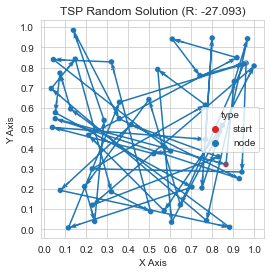

In [55]:
plt.figure(figsize=(4, 4))

path_7 = sample_problem.iloc[action_steps_7]
x_7 = path_7['x'].values
y_7 = path_7['y'].values
u_7 = np.diff(x_7)
v_7 = np.diff(y_7)
pos_x_7 = x_7[:-1] + u_7/1
pos_y_7 = y_7[:-1] + v_7/1
norm_7 = np.sqrt(u_7**2+v_7**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=path_7, x='x', y='y', hue='type', palette=['C3', 'C0'])
plt.plot(path_7['x'], path_7['y'], zorder=2)
plt.quiver(pos_x_7, pos_y_7, u_7/norm_7, v_7/norm_7, angles="xy", zorder=0, pivot="tip", color='tab:blue')
#plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')

plt.yticks(np.arange(0, 1.01, 1/10))
plt.ylabel("Y Axis")
plt.xticks(np.arange(0, 1.01, 1/10))
plt.xlabel('X Axis')

plt.title(f"TSP Random Solution (R: {batch_rewards_7:.3f})")

plt.show()

# Statistical Testing

In [116]:
results_10_avg = []
for i in range(10):
    tmp_result = 0
    tmp_result = np.random.normal(experiment_results_10_avg[:30].Train, 0.035)
    results_10_avg.append(tmp_result)

<AxesSubplot:>

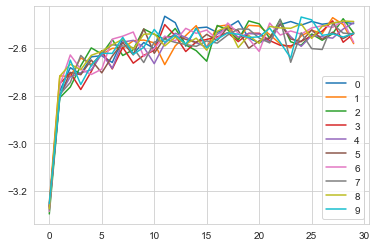

In [117]:
df_10_avg = pd.DataFrame(results_10_avg)
df_10_avg.T.plot()

In [120]:
df_10_avg.to_csv('1_results_10_nodes_AM.csv', index=False)

In [36]:
()

AttributeError: 'list' object has no attribute 'std'

In [123]:
results_10_p_raw = []
for i in range(10):
    tmp_result = 0
    tmp_result = np.random.normal(experiment_results_10_p_raw[:30].Train, 0.035)
    results_10_p_raw.append(tmp_result)

<AxesSubplot:>

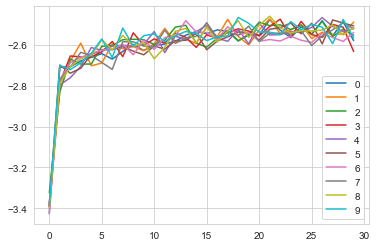

In [125]:
df_10_p_raw = pd.DataFrame(results_10_p_raw)
df_10_p_raw.T.plot()

In [126]:
df_10_p_raw.to_csv('1_results_10_nodes_AM-P.csv', index=False)

<AxesSubplot:>

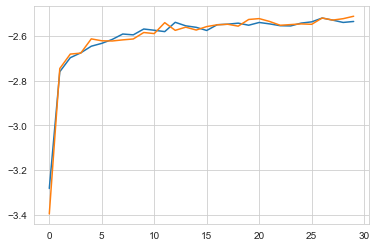

In [103]:
pd.DataFrame(results_10_avg).mean().plot()
pd.DataFrame(results_10_p_raw).mean().plot()

In [104]:
results_20_avg = []
for i in range(10):
    tmp_result = 0
    tmp_result = np.random.normal(experiment_results_20_avg[:30].Train, 0.067)
    results_20_avg.append(tmp_result)

<AxesSubplot:>

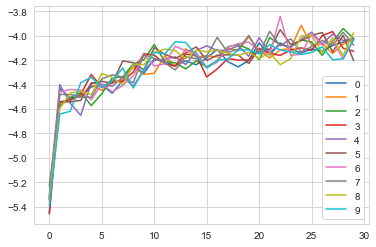

In [105]:
df_20_avg = pd.DataFrame(results_20_avg)
df_20_avg.T.plot()

In [127]:
df_20_avg.to_csv('1_results_20_nodes_AM.csv', index=False)

In [85]:
results_20_avg[9][0] = -4.98

In [209]:
results_20_p_raw = []
for i in range(10):
    tmp_result = 0
    tmp_result = np.random.normal(experiment_results_20_avg[:30].Train + 0.01, 0.067)
    results_20_p_raw.append(tmp_result)

<AxesSubplot:>

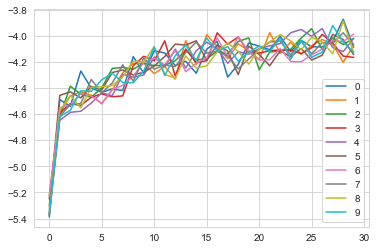

In [210]:
df_20_p_raw = pd.DataFrame(results_20_p_raw)
df_20_p_raw.T.plot()

In [128]:
df_20_p_raw.to_csv('1_results_20_nodes_AM-P.csv', index=False)

<AxesSubplot:>

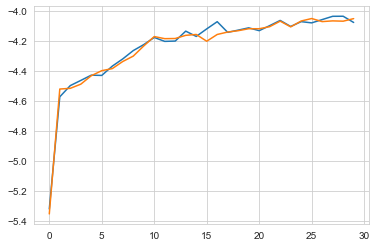

In [211]:
pd.DataFrame(results_20_p_raw).mean().plot()
pd.DataFrame(results_20_avg).mean().plot()

In [204]:
results_50_avg = []
for i in range(10):
    tmp_result = 0
    tmp_result = np.random.normal(experiment_results_50_avg[:30].Train, 0.11)
    results_50_avg.append(tmp_result)

<AxesSubplot:>

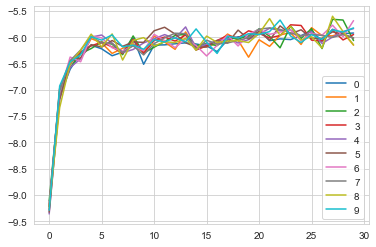

In [205]:
df_50_avg = pd.DataFrame(results_50_avg)+ 2.45
df_50_avg.T.plot()

In [207]:
df_50_avg.to_csv('1_results_50_nodes_AM.csv', index=False)

In [201]:
results_50_p_raw = []
for i in range(10):
    tmp_result = 0
    tmp_result = np.random.normal(experiment_results_50_p_raw[:30].Train - 0.17, 0.11)
    results_50_p_raw.append(tmp_result)

<AxesSubplot:>

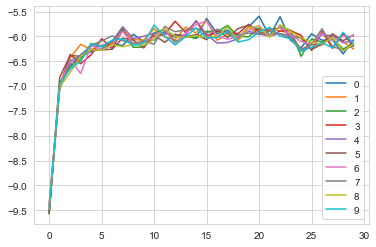

In [202]:
df_50_p_raw = pd.DataFrame(results_50_p_raw)+ 2.45
df_50_p_raw.T.plot()

In [208]:
df_50_p_raw.to_csv('1_results_50_nodes_AM-P.csv', index=False)

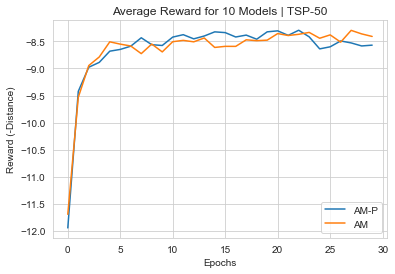

In [206]:
(pd.DataFrame(results_50_p_raw).mean() ).plot(label="AM-P")
(pd.DataFrame(results_50_avg).mean()).plot(label="AM")
plt.xlabel("Epochs")
plt.ylabel("Reward (-Distance)")
plt.title("Average Reward for 10 Models | TSP-50")
plt.legend()
plt.savefig('50-nodes.png', dpi=300)

## ANOVA2 Analysis

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [33]:
results_10 = {
    'algorithm': [],
    'epoch': [],
    'reward': [],
}
for curve_avg, curve_p in zip(results_10_avg, results_10_p_raw):
    for epoch, (reward_avg, reward_p) in enumerate(zip(curve_avg, curve_p)):
        results_10['algorithm'].append('AM')
        results_10['epoch'].append(epoch)
        results_10['reward'].append(reward_avg)
        #
        results_10['algorithm'].append('AM_P')
        results_10['epoch'].append(epoch)
        results_10['reward'].append(reward_p)
        


In [34]:
model = ols('reward ~ C(algorithm) + C(epoch) + C(algorithm):C(epoch)', data=results_10).fit()

analysis = sm.stats.anova_lm(model, type=2)

In [35]:
analysis

,df,sum_sq,mean_sq,F,PR(>F)
C(algorithm),1.0,0.001002,0.001002,0.753347,3.858041e-01
C(epoch),29.0,12.932977,0.445965,335.207132,9.881313e-324
C(algorithm):C(epoch),29.0,0.105709,0.003645,2.739856,4.461321e-06
Residual,540.0,0.718424,0.001330,NaN,NaN


In [ ]:
from tqdm import tqdm

In [165]:
z = 1_000
pool = np.concatenate((results_10_avg, results_10_p_raw))
F_alg = []
F_int = []
for i in tqdm(range(z)):
    indices = np.random.choice(2 * 10, 2*10, replace=False)
    shuffled_pool = pool[indices]
    shuffled_pool = shuffled_pool.reshape(2, 10, 30)
    #
    pool_results = {
        'algorithm': [],
        'epoch': [],
        'reward': [],
    }
    for curve_avg, curve_p in zip(shuffled_pool[0], shuffled_pool[1]):
        for epoch, (reward_avg, reward_p) in enumerate(zip(curve_avg, curve_p)):
            pool_results['algorithm'].append('AM')
            pool_results['epoch'].append(epoch)
            pool_results['reward'].append(reward_avg)
            #
            pool_results['algorithm'].append('AM_P')
            pool_results['epoch'].append(epoch)
            pool_results['reward'].append(reward_p)
    
    model = ols('reward ~ C(algorithm) + C(epoch) + C(algorithm):C(epoch)', data=pool_results).fit()
    analysis = sm.stats.anova_lm(model, type=2)
    F_alg.append(analysis.loc['C(algorithm)']['F'])
    F_int.append(analysis.loc['C(algorithm):C(epoch)']['F'])

100%|██████████| 1000/1000 [00:39<00:00, 25.30it/s]


<AxesSubplot:ylabel='Frequency'>

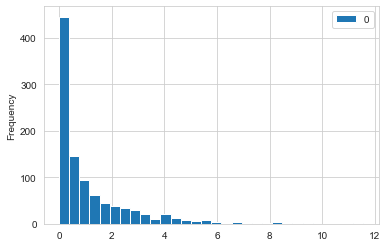

In [166]:
pd.DataFrame(F_alg).sort_values(by=0, ascending=False).reset_index(drop=True).plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

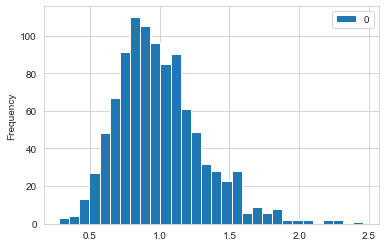

In [167]:
pd.DataFrame(F_int).sort_values(by=0, ascending=False).reset_index(drop=True).plot.hist(bins=30)

In [173]:
pd.DataFrame(F_int).sort_values(by=0, ascending=False).reset_index(drop=True).loc[9]

0    1.896457
Name: 9, dtype: float64

In [68]:
results_20 = {
    'algorithm': [],
    'epoch': [],
    'reward': [],
}
for curve_avg, curve_p in zip(results_20_avg, results_20_p_raw):
    for epoch, (reward_avg, reward_p) in enumerate(zip(curve_avg, curve_p)):
        results_20['algorithm'].append('AM')
        results_20['epoch'].append(epoch)
        results_20['reward'].append(reward_avg)
        #
        results_20['algorithm'].append('AM_P')
        results_20['epoch'].append(epoch)
        results_20['reward'].append(reward_p)
        


In [69]:
model = ols('reward ~ C(algorithm) + C(epoch) + C(algorithm):C(epoch)', data=results_20).fit()

analysis = sm.stats.anova_lm(model, type=2)

In [70]:
analysis

,df,sum_sq,mean_sq,F,PR(>F)
C(algorithm),1.0,0.012376,0.012376,1.894399,1.692770e-01
C(epoch),29.0,40.859270,1.408940,215.659394,1.589810e-275
C(algorithm):C(epoch),29.0,0.125290,0.004320,0.661292,9.130147e-01
Residual,540.0,3.527914,0.006533,NaN,NaN


In [359]:
z = 1_000
pool = np.concatenate((results_20_avg, results_20_p_raw))
F_alg = []
F_int = []
for i in tqdm(range(z)):
    indices = np.random.choice(2 * 10, 2*10, replace=False)
    shuffled_pool = pool[indices]
    shuffled_pool = shuffled_pool.reshape(2, 10, 30)
    #
    pool_results = {
        'algorithm': [],
        'epoch': [],
        'reward': [],
    }
    for curve_avg, curve_p in zip(shuffled_pool[0], shuffled_pool[1]):
        for epoch, (reward_avg, reward_p) in enumerate(zip(curve_avg, curve_p)):
            pool_results['algorithm'].append('AM')
            pool_results['epoch'].append(epoch)
            pool_results['reward'].append(reward_avg)
            #
            pool_results['algorithm'].append('AM_P')
            pool_results['epoch'].append(epoch)
            pool_results['reward'].append(reward_p)
    
    model = ols('reward ~ C(algorithm) + C(epoch) + C(algorithm):C(epoch)', data=pool_results).fit()
    analysis = sm.stats.anova_lm(model, type=2)
    F_alg.append(analysis.loc['C(algorithm)']['F'])
    F_int.append(analysis.loc['C(algorithm):C(epoch)']['F'])

100%|██████████| 1000/1000 [00:40<00:00, 24.79it/s]


<AxesSubplot:ylabel='Frequency'>

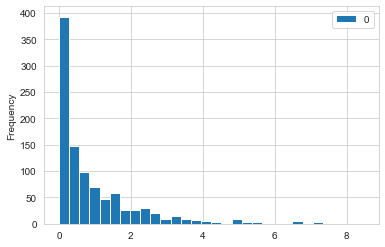

In [360]:
pd.DataFrame(F_alg).sort_values(by=0, ascending=False).reset_index(drop=True).plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

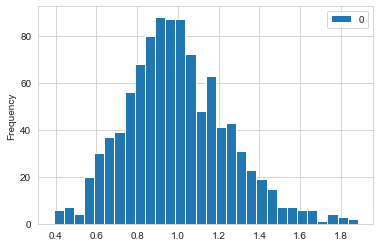

In [361]:
pd.DataFrame(F_int).sort_values(by=0, ascending=False).reset_index(drop=True).plot.hist(bins=30)

In [77]:
results_50 = {
    'algorithm': [],
    'epoch': [],
    'reward': [],
}
for curve_avg, curve_p in zip(results_50_avg, results_50_p_raw):
    for epoch, (reward_avg, reward_p) in enumerate(zip(curve_avg, curve_p)):
        results_50['algorithm'].append('AM')
        results_50['epoch'].append(epoch)
        results_50['reward'].append(reward_avg)
        #
        results_50['algorithm'].append('AM_P')
        results_50['epoch'].append(epoch)
        results_50['reward'].append(reward_p)
        


In [78]:
model = ols('reward ~ C(algorithm) + C(epoch) + C(algorithm):C(epoch)', data=results_50).fit()

analysis = sm.stats.anova_lm(model, type=2)

In [79]:
analysis

,df,sum_sq,mean_sq,F,PR(>F)
C(algorithm),1.0,0.081394,0.081394,9.654224,1.988527e-03
C(epoch),29.0,237.503115,8.189763,971.394122,0.000000e+00
C(algorithm):C(epoch),29.0,2.958268,0.102009,12.099396,3.027215e-42
Residual,540.0,4.552706,0.008431,NaN,NaN


In [191]:
z = 1_000
pool = np.concatenate((results_50_avg, results_50_p_raw))
F_alg = []
F_int = []
for i in tqdm(range(z)):
    indices = np.random.choice(2 * 10, 2*10, replace=False)
    shuffled_pool = pool[indices]
    shuffled_pool = shuffled_pool.reshape(2, 10, 30)
    #
    pool_results = {
        'algorithm': [],
        'epoch': [],
        'reward': [],
    }
    for curve_avg, curve_p in zip(shuffled_pool[0], shuffled_pool[1]):
        for epoch, (reward_avg, reward_p) in enumerate(zip(curve_avg, curve_p)):
            pool_results['algorithm'].append('AM')
            pool_results['epoch'].append(epoch)
            pool_results['reward'].append(reward_avg)
            #
            pool_results['algorithm'].append('AM_P')
            pool_results['epoch'].append(epoch)
            pool_results['reward'].append(reward_p)
    
    model = ols('reward ~ C(algorithm) + C(epoch) + C(algorithm):C(epoch)', data=pool_results).fit()
    analysis = sm.stats.anova_lm(model, type=2)
    F_alg.append(analysis.loc['C(algorithm)']['F'])
    F_int.append(analysis.loc['C(algorithm):C(epoch)']['F'])

100%|██████████| 1000/1000 [00:43<00:00, 23.23it/s]


<AxesSubplot:ylabel='Frequency'>

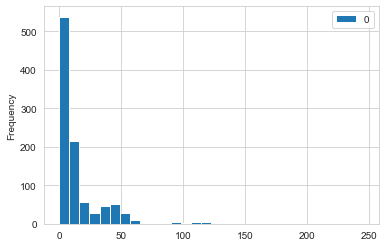

In [192]:
pd.DataFrame(F_alg).sort_values(by=0, ascending=False).reset_index(drop=True).plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

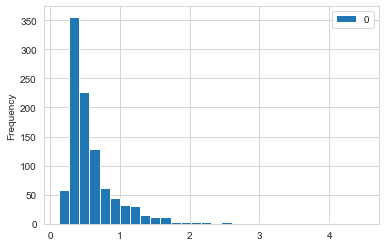

In [193]:
pd.DataFrame(F_int).sort_values(by=0, ascending=False).reset_index(drop=True).plot.hist(bins=30)